In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import tensorflow as tf
import datetime
from sklearn import linear_model

root_dir = "D:/Jupyter/";

In [164]:
def gen2d_circle(r, x0 = np.array([[0,0]]), num=100, dr_sigma=1):
    rs = np.exp(np.random.normal(np.log(r), dr_sigma, num)).reshape(num, 1)
    phis = np.array(np.random.uniform(0, 2*np.pi, num)).reshape(num, 1)
    return x0 + np.hstack([np.cos(phis)*rs, np.sin(phis)*rs])


def mark2d_half(x, n, x0 = np.array([[0,0]]), uncertainty=0.1, prob=0.5):
    num = x.shape[0]
    unc = (np.random.uniform(0, 1, num) < uncertainty) * 1
    xt = x - x0
    xd = np.matmul(xt, n)
    return np.array([unc[i] * np.random.binomial(1, prob) + (1-unc[i]) * (xd[i] > 0) for i in range(num)]).reshape(num, 1)

def mark2d_circle(x, r, x0 = np.array([[0,0]]), uncertainty=0.1, prob=0.5):
    num = x.shape[0]
    unc = (np.random.uniform(0, 1, num) < uncertainty) * 1
    xt = x - x0
    r2 = r*r
    xd2 = [np.dot(p, p) for p in xt]
    return np.array([unc[i] * np.random.binomial(1, prob) + (1-unc[i]) * (xd2[i] < r2) for i in range(num)]).reshape(num, 1)

def mini_batch(X, y, num=1000):
    rnd = np.random.uniform(0,1,X.shape[0])
    #print(rnd)
    cutoff = sorted(rnd)[num]
    return X[rnd < cutoff,:], y[rnd < cutoff]

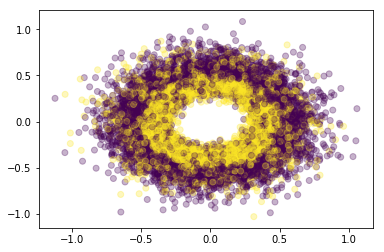

In [90]:
pts = gen2d_circle(0.5, num=10000, dr_sigma=0.25)
#pmrks = mark2d_circle(pts, 0.5, uncertainty=0.5, prob=0.5)
pmrks_lin = mark2d_half(pts, np.array([np.cos(np.pi/6), np.sin(np.pi/6)]).reshape(2,1), uncertainty=0.5, prob=0.5)
pmrks = mark2d_circle(pts, 0.5, uncertainty=0.5, prob=0.5)
plt.scatter(pts[:, 0], pts[:, 1], c=pmrks, alpha=0.3)

In [74]:
#1 Output Layer

dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
log_dir = root_dir + 'Logs/' + dt_now
tf.reset_default_graph()

tf_X = tf.placeholder(name="X", dtype=tf.float32, shape=(2, None))
tf_y = tf.placeholder(name="y", dtype=tf.float32, shape=(1, None))
tf_num = tf.placeholder(name='num', dtype=tf.float32, shape=())

tf_w0 = tf.Variable(0, name="w0", dtype=tf.float32)
tf_w = tf.Variable(np.random.normal(0, 0.5, 2).reshape(2,1), name="w", dtype=tf.float32)

tf_N = 1 / (1 + tf.exp(tf_w0 + tf.matmul(tf.transpose(tf_w), tf_X)))

tf_err = -(tf.matmul(tf_y, tf.log(tf.transpose(tf_N))) + tf.matmul(1 - tf_y,  tf.log(tf.transpose(1 - tf_N)))) / tf_num

tf_opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
tf_train = tf_opt.minimize(tf_err)

tf_init = tf.global_variables_initializer() 

file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

[[-2.18332028]
 [-1.16071486]] -0.0236044
[[-2.36041832]
 [-1.26398885]] -0.0240032
[[-2.37764001]
 [-1.27343154]] -0.0240459
[[-2.37934184]
 [-1.27433956]] -0.0240502
[[-2.37948132]
 [-1.27441454]] -0.0240506
[[-2.37948132]
 [-1.27441454]] -0.0240506
[[-2.37948132]
 [-1.27441454]] -0.0240506
[[-2.37948132]
 [-1.27441454]] -0.0240506
[[-2.37948132]
 [-1.27441454]] -0.0240506
[[-2.37948132]
 [-1.27441454]] -0.0240506


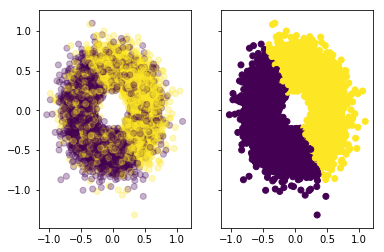

In [83]:
with tf.Session() as sess:
    sess.run(tf_init)
    for i in range(10):
        for j in range(1000):
            tf_train.run(feed_dict={tf_X: pts.transpose(), tf_y:pmrks.transpose(), tf_num:pts.shape[0]})
        print(tf_w.eval(), tf_w0.eval())
    yN = tf_N.eval(feed_dict={tf_X: pts.transpose(), tf_y:pmrks.transpose()})
yNf = 1.0*(yN > 0.5)
fig,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.scatter(pts[:, 0], pts[:, 1], c=pmrks, alpha=0.3)
ax2.scatter(pts[:, 0], pts[:, 1], c=yNf)

In [227]:
#2: Output Layer with command

def mkNeuronLayer(name, X_in, num, sigma=0.1, activation='logit'):
    with tf.name_scope(name) as scope:
        tf_alpha = tf.Variable(np.random.normal(0, sigma, num).reshape(num,1),
                               dtype=tf.float32, name='intercepts')
        tf_beta = tf.Variable(np.random.normal(0, sigma, (num, X_in.get_shape()[0])),
                              dtype=tf.float32, name='weights')
        tf_Z = tf_alpha + tf.matmul(tf_beta, X_in)
        if activation == 'logit':
            tf_Out = 1 / (1 + tf.exp(tf_Z))
            return tf_Out
        elif activation == 'relu':
            tf_Out = tf.nn.relu(tf_Z)
            return tf_Out
        elif activation == 'elu':
            tf_Out = tf.nn.elu(tf_Z)
            return tf_Out
        else:
            tf_Out = tf_Z
            return tf_Out

dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
log_dir = root_dir + 'Logs/' + dt_now
tf.reset_default_graph()

tf_X = tf.placeholder(name="X", dtype=tf.float32, shape=(2, None))
tf_y = tf.placeholder(name="y", dtype=tf.float32, shape=(1, None))
tf_num = tf.placeholder(name='num', dtype=tf.float32, shape=())

tf_L1 = mkNeuronLayer('hidden_1', tf_X, 10, activation='lin')
tf_N = mkNeuronLayer('output', tf_L1, 1, activation='logit')

tf_err = -(tf.matmul(tf_y, tf.log(tf.transpose(tf_N))) + tf.matmul(1 - tf_y,  tf.log(tf.transpose(1 - tf_N)))) / tf_num
tf_err_summary = tf.summary.scalar('ERR', tf.reduce_mean(tf_err))
tf_opt = tf.train.GradientDescentOptimizer(learning_rate=1)
tf_train = tf_opt.minimize(tf_err)

tf_init = tf.global_variables_initializer() 

file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epoch ended:  [[ 0.69303286]]
epoch ended:  [[ 0.69465256]]
epoch ended:  [[ 0.69290227]]
epoch ended:  [[ 0.69426054]]
epoch ended:  [[ 0.69377714]]
epoch ended:  [[ 0.69279617]]
epoch ended:  [[ 0.69308215]]
epoch ended:  [[ 0.69420594]]
epoch ended:  [[ 0.69274789]]
epoch ended:  [[ 0.69292003]]


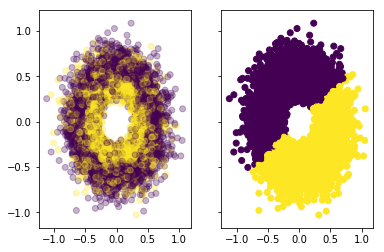

In [228]:
yN = None
batch_size = 1000
num_epochs = 10
num_steps = 1000
with tf.Session() as sess:
    sess.run(tf_init)
    full_batch = {tf_X: pts.transpose(), tf_y:pmrks.transpose(), tf_num:pts.shape[0]}
    for i in range(num_epochs):
        X0,y0 = mini_batch(pts, pmrks,num=batch_size)
        batch = {tf_X: X0.transpose(), tf_y:y0.transpose(), tf_num:X0.shape[0]}
        for j in range(num_steps):
            tf_train.run(feed_dict=batch)
            
        cur_err = tf_err.eval(feed_dict=full_batch)
        summary_str = tf_err_summary.eval(feed_dict=full_batch)
        file_writer.add_summary(summary_str, i)
        print('epoch ended: ', cur_err)
    yN = tf_N.eval(feed_dict=full_batch)
    yNf = 1.0*(yN > np.percentile(yN, 50))
    fig,(ax1,ax2)=plt.subplots(1,2,sharey=True)
    ax1.scatter(pts[:,0], pts[:,1], c=pmrks, alpha=0.3)
    ax2.scatter(pts[:,0], pts[:,1], c=yNf)

In [144]:
#2: Output Layer with command

tf_fc = tf.contrib.learn.infer_real_valued_columns_from_input(pts)
tf_dnnc = tf.contrib.learn.DNNClassifier(hidden_units = [3], n_classes=2, feature_columns=tf_fc)
tf_dnnc = tf.contrib.learn.SKCompat(tf_dnnc)
tf_dnnc.fit(pts, pmrks, batch_size=1000, steps=10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001ED54E38C50>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\KolhiziN\\AppData\\Local\\Temp\\tmpdfxw1v7o'}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no 

INFO:tensorflow:loss = 0.620861, step = 6601 (0.264 sec)
INFO:tensorflow:global_step/sec: 347.22
INFO:tensorflow:loss = 0.621629, step = 6701 (0.288 sec)
INFO:tensorflow:global_step/sec: 320.259
INFO:tensorflow:loss = 0.616241, step = 6801 (0.312 sec)
INFO:tensorflow:global_step/sec: 352.073
INFO:tensorflow:loss = 0.612266, step = 6901 (0.284 sec)
INFO:tensorflow:global_step/sec: 505.335
INFO:tensorflow:loss = 0.614812, step = 7001 (0.210 sec)
INFO:tensorflow:global_step/sec: 466.475
INFO:tensorflow:loss = 0.628752, step = 7101 (0.199 sec)
INFO:tensorflow:global_step/sec: 463.551
INFO:tensorflow:loss = 0.611903, step = 7201 (0.216 sec)
INFO:tensorflow:global_step/sec: 423.848
INFO:tensorflow:loss = 0.606628, step = 7301 (0.240 sec)
INFO:tensorflow:global_step/sec: 337.84
INFO:tensorflow:loss = 0.61987, step = 7401 (0.296 sec)
INFO:tensorflow:global_step/sec: 459.998
INFO:tensorflow:loss = 0.636822, step = 7501 (0.213 sec)
INFO:tensorflow:global_step/sec: 434.859
INFO:tensorflow:loss = 

SKCompat()

INFO:tensorflow:Restoring parameters from C:\Users\KolhiziN\AppData\Local\Temp\tmpdfxw1v7o\model.ckpt-10000


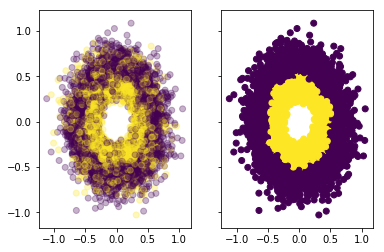

In [145]:
yNf = tf_dnnc.predict(pts)['classes']
fig,(ax1,ax2)=plt.subplots(1,2,sharey=True)
ax1.scatter(pts[:, 0], pts[:, 1], c=pmrks, alpha=0.3)
ax2.scatter(pts[:, 0], pts[:, 1], c=yNf)

In [118]:
yNf

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [146]:
tmp = np.random.uniform(0,1,100)
cutoff = sorted(tmp)[50]

In [159]:
mini_batch(pts, pmrks, num=100)

[ 0.53992467  0.49010861  0.50916564 ...,  0.43112872  0.60590305
  0.57321375]


(array([[ 0.51374564,  0.27907832],
        [ 0.33745112,  0.25464774],
        [-0.35077621, -0.24781193],
        [-0.17250967,  0.43421609],
        [ 0.35313623,  0.37721199],
        [ 0.32742992, -0.07182463],
        [-0.23796787,  0.36805462],
        [-0.40583857, -0.52382489],
        [ 0.54465038, -0.15160435],
        [-0.03956574, -0.37382754],
        [-0.35129472,  0.35904816],
        [ 0.40362826,  0.12094633],
        [-0.4618002 ,  0.44738754],
        [-0.37100162, -0.30300552],
        [-0.55437075,  0.08108116],
        [-0.4114786 ,  0.2806206 ],
        [-0.35085699,  0.14553285],
        [-0.27945572, -0.44843662],
        [-0.45181649, -0.08962996],
        [ 0.57370547,  0.28541828],
        [-0.34062171, -0.45535034],
        [-0.38652316,  0.22985244],
        [-0.28561682,  0.39437203],
        [-0.1247126 , -0.28722968],
        [-0.3767068 , -0.05559718],
        [ 0.26790128, -0.53172295],
        [ 0.31987105,  0.33321618],
        [-0.11032983,  0.414

In [ ]:
#3: Output Layer with command and custom gradient

def mkNeuronLayerCalc(name, X_in, num, sigma=0.1):
    with tf.name_scope(name) as scope:
        tf_alpha = tf.Variable(np.random.normal(0, sigma, num).reshape(num,1),
                               dtype=tf.float32, name='intercepts')
        tf_beta = tf.Variable(np.random.normal(0, sigma, (num, X_in.get_shape()[0])),
                              dtype=tf.float32, name='weights')
        tf_Z = tf_alpha + tf.matmul(tf_beta, X_in)
        tf_Out = 1 / (1 + tf.exp(tf_Z))
        return (tf_Out, tf_alpha, tf_beta)
        
#1 - Output: dLoss / dw
# dLoss / dw = dLoss / dN * dN / dZ * dZ / dw
#    dLoss / dN = y/N-(1-y)/(1-N) = {y(1-N)-N(1-y)=y-N} = (y - N)/(N(1-N))
#    dN / dZ = s' = -s(1-s) = -N(1-N)
# dLoss / dw = -(y-N) * dZ/dw

#2 - Hidden: dLoss / dwh
# dLoss / dwh = dLoss / dNh * dNh / dZh * dZh / dwh
#    dLoss / dNh = dLoss / dZ * dZ / dNh = -(y-N)*w
#    dNh / dZh = -Nh(1-Nh)
# dLoss / dwh = dLoss / dZ * w * (-Nh) * (1 - Nh)
# dLoss / dZh = dLoss / dZ * dZ / dNh * dNh / dZh = dLoss / dZ * w * (-Nh) * (1 - Nh)

# dLoss / dwh = dLoss / dZh * dZh / dwh = dLoss / dZh * input
        
def mkNeuronLayerDLDZ(name, dLdZ_next, tf_Out, tf_beta_next):
    with tf.name_scope(name) as scope:
        return dLdZ_next * tf_beta_next * (-tf_Out) * (1 - tf_Out)
    
def mkNeuronLayerDLDW(name, dLdZ, tf_In):
    with tf.name_scope(name) as scope:
        return dLdZ * tf_In
        
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
log_dir = root_dir + 'Logs/' + dt_now
tf.reset_default_graph()

tf_X = tf.placeholder(name="X", dtype=tf.float32, shape=(2, None))
tf_y = tf.placeholder(name="y", dtype=tf.float32, shape=(1, None))
tf_num = tf.placeholder(name='num', dtype=tf.float32, shape=())

(tf_L1, tf_L1_alpha, tf_L1_beta) = mkNeuronLayer('hidden_1', tf_X, 3)
(tf_N, tf_N_alpha, tf_N_beta) = mkNeuronLayer('output', tf_L1, 1)
mkNeuronLayerDLDZ('output', |LOSS|, tf_N, 1?)
mkNeuronLayerDLDW('output', )


tf_err = -(tf.matmul(tf_y, tf.log(tf.transpose(tf_N))) + tf.matmul(1 - tf_y,  tf.log(tf.transpose(1 - tf_N)))) / tf_num
tf_err_summary = tf.summary.scalar('ERR', tf.reduce_mean(tf_err))
tf_opt = tf.train.GradientDescentOptimizer(learning_rate=1)
tf_train = tf_opt.minimize(tf_err)

tf_init = tf.global_variables_initializer() 

file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())